#### Pavlo Yatluk
#### dz_46

### ЗАВДАННЯ

#### Використовуючи датасет з файлу cardox.csv (об’єми продажів мережі супермаркетів) виконайте наступну роботу:              1. Проведіть попередній аналіз даних. 2. Скорегуйте виявлені аномалії. 3. Проведіть необхідні попередні підготовки даних (декомпозиція, коригування ряду, заповнення пропущених значень і. т. і.). 4. Оберіть модель і проведіть оцінку її метрик             5. Проведіть кінцеву діагностику для отриманої моделі.  6.  Виконайте прогноз на 30 років Збережіть результати прогнозування у файл


#### 1. Попередній аналіз даних

In [47]:
# імпортуємо бібліотеки
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import compress, product

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [48]:
# функції визначення сезонності та метрики
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()
    
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

In [49]:
# імпорт датасету
df = pd.read_excel('cardox.xls',index_col='date')
df

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


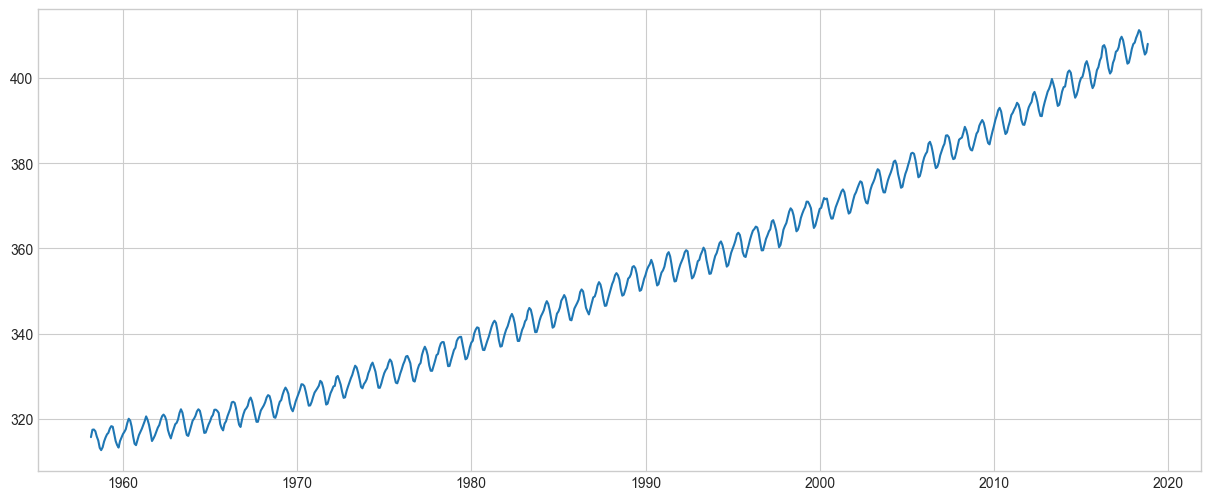

In [50]:
# візуалізація даних
plt.figure(figsize=(15, 6))
plt.plot(df)
plt.show()

In [51]:
# опис базових статистик датасету
df.describe()

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


#### 2. Скорегуйте виявлені аномалії

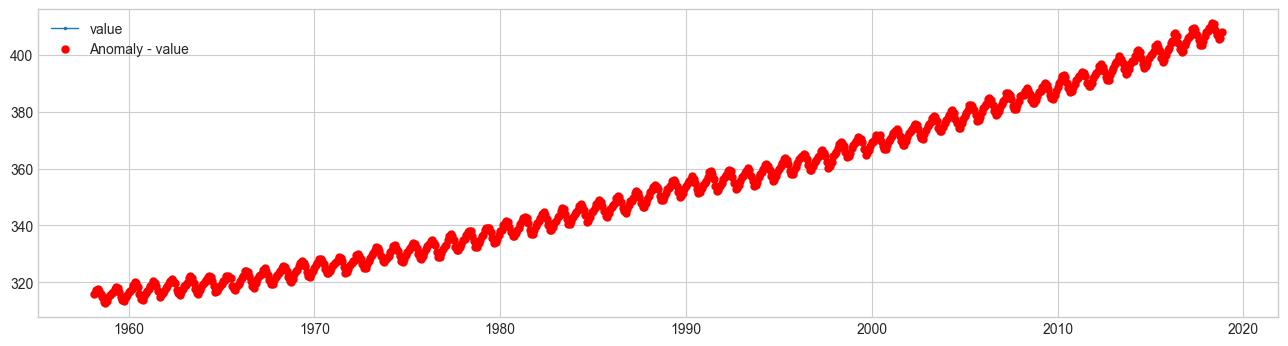

In [52]:
# оцінка викидів ThresholdAD
threshold_ad = ThresholdAD(high=2800, low=800)
anomalies = threshold_ad.detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

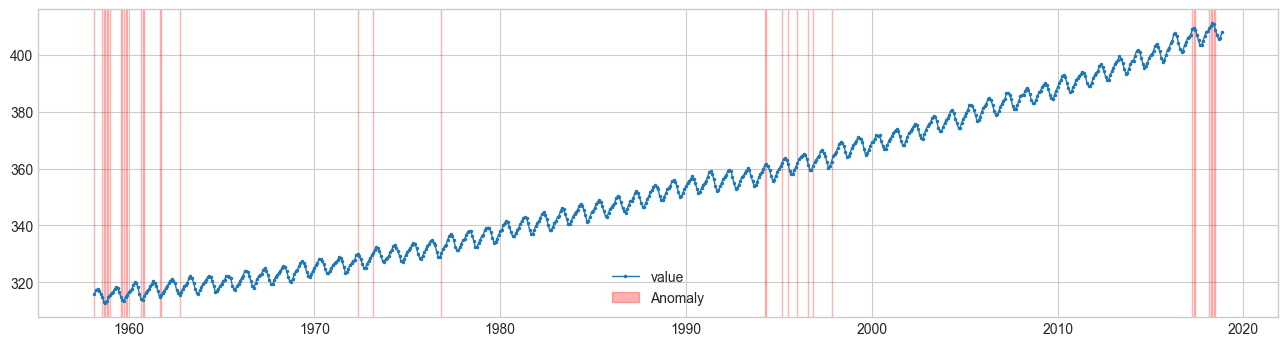

In [53]:
# оцінка викидів OutlierDetector
from sklearn.neighbors import LocalOutlierFactor
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [54]:
# аномальні дати
anomalies[anomalies]

date
1958-03-01    True
1958-08-01    True
1958-09-01    True
1958-10-01    True
1958-11-01    True
1958-12-01    True
1959-01-01    True
1959-08-01    True
1959-09-01    True
1959-10-01    True
1959-11-01    True
1959-12-01    True
1960-09-01    True
1960-10-01    True
1960-11-01    True
1961-09-01    True
1961-10-01    True
1962-10-01    True
1972-05-01    True
1973-03-01    True
1976-11-01    True
1994-04-01    True
1994-05-01    True
1995-03-01    True
1995-07-01    True
1996-01-01    True
1996-08-01    True
1996-11-01    True
1997-11-01    True
2017-04-01    True
2017-05-01    True
2017-06-01    True
2018-03-01    True
2018-04-01    True
2018-05-01    True
2018-06-01    True
2018-07-01    True
dtype: bool

#### 3. Проведіть необхідні попередні підготовки даних (декомпозиція, коригування ряду, заповнення пропущених значень і. т. і.).

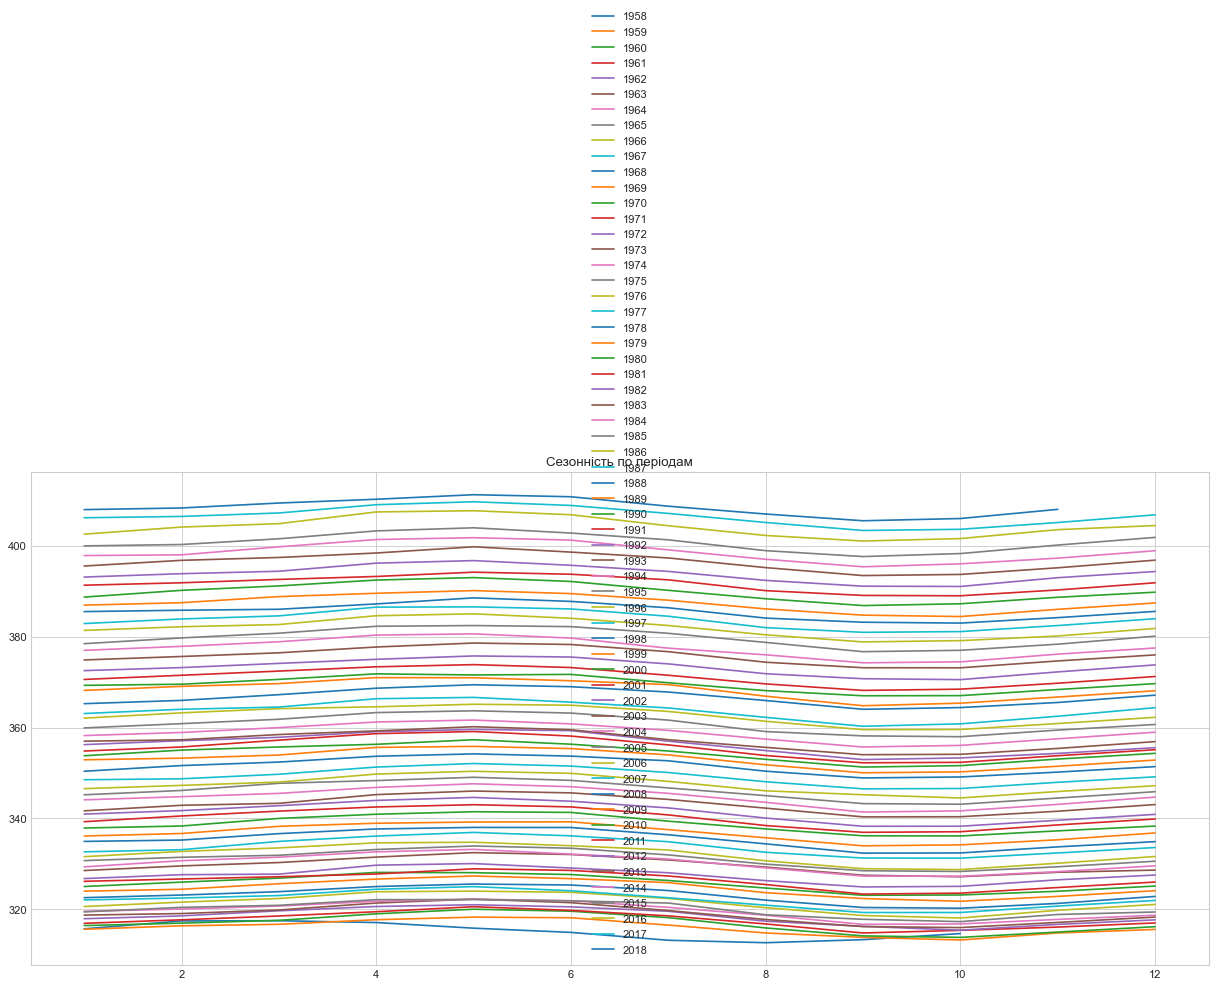

In [55]:
# графік сезонності з функцією sesonal
sesonal(df,12)

Text(0.5, 0.98, 'Мультиплікатива модель')

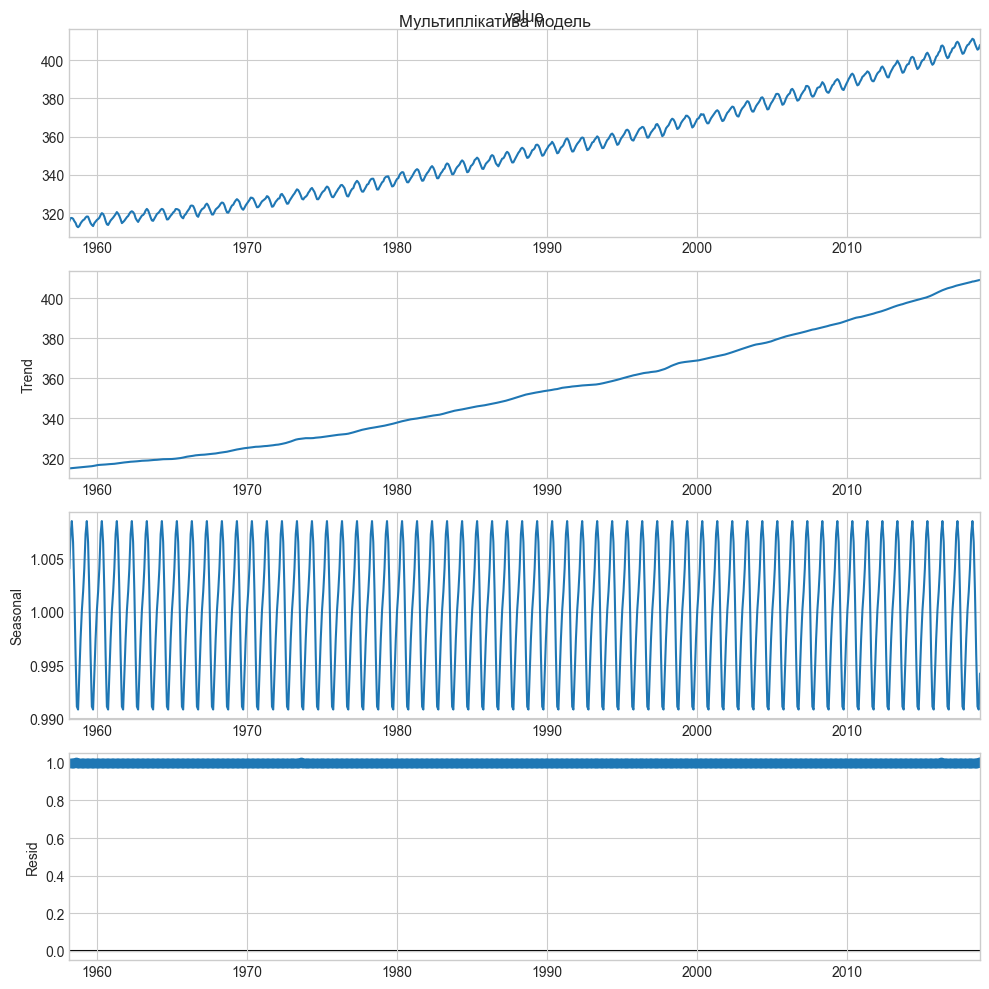

In [56]:
# мульимплікативна модель декомпозиції
result_M = seasonal_decompose(df.value, model='multiplicative', extrapolate_trend=12)
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель')

In [57]:
# значення після проведення мульимплікативної декомпозиції
result_M.seasonal['1990']

date
1990-01-01    1.000135
1990-02-01    1.001929
1990-03-01    1.004054
1990-04-01    1.007302
1990-05-01    1.008530
1990-06-01    1.006555
1990-07-01    1.001988
1990-08-01    0.995917
1990-09-01    0.991096
1990-10-01    0.990812
1990-11-01    0.994200
1990-12-01    0.997482
Name: seasonal, dtype: float64

Text(0.5, 0.98, 'Адитивная модель')

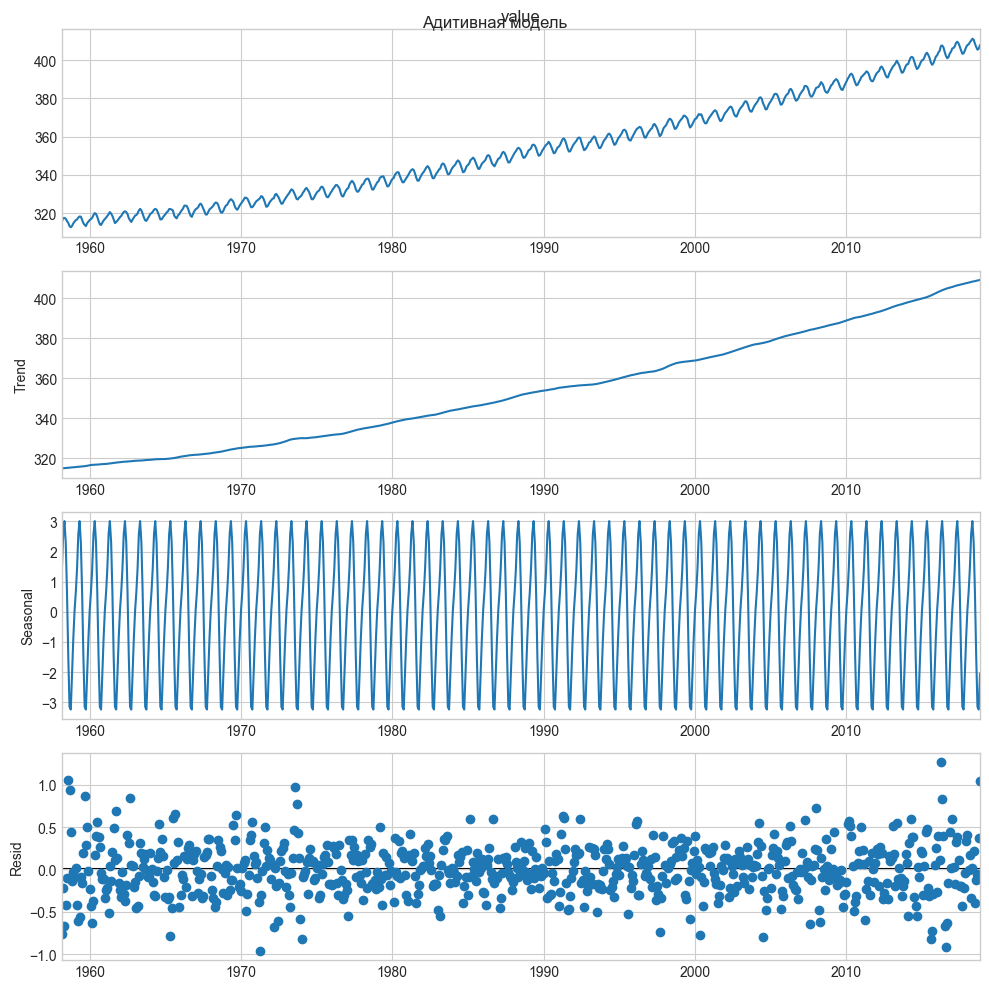

In [58]:
# адитивна модель декомпозиції
result_A = seasonal_decompose(df.value, model='additive', extrapolate_trend=12)
plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Адитивная модель')

In [59]:
# значення після проведення мульимплікативної декомпозиції
result_A.seasonal['1990']

date
1990-01-01    0.059289
1990-02-01    0.688213
1990-03-01    1.435042
1990-04-01    2.579879
1990-05-01    3.010959
1990-06-01    2.308198
1990-07-01    0.687431
1990-08-01   -1.456150
1990-09-01   -3.152087
1990-10-01   -3.241776
1990-11-01   -2.041328
1990-12-01   -0.877669
Name: seasonal, dtype: float64

#### 4. Оберіть модель і проведіть оцінку її метрик
#### Модель Хольта-Вінтерса

In [60]:
# тренувальний та тестувальний діапазони
train = df['1990':'2017']
test = df['2018']

In [61]:
# тренування моделі
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()

In [62]:
# параметри моделі після тренування
fit1.params

{'smoothing_level': 0.6259672229940434,
 'smoothing_trend': 0.014403160796011071,
 'smoothing_seasonal': 1.1174072943406578e-11,
 'damping_trend': nan,
 'initial_level': 354.77238127224166,
 'initial_trend': 0.12425476691932988,
 'initial_seasons': array([0.99732723, 0.99900532, 1.0009614 , 1.00406963, 1.00509378,
        1.00290089, 0.99817719, 0.99226754, 0.98786208, 0.987975  ,
        0.99134339, 0.99473143]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [63]:
# значення датасету тренувальної моделі
fit1.fittedvalues

date
1990-01-01    353.948080
1990-02-01    354.573574
1990-03-01    355.687623
1990-04-01    356.946755
1990-05-01    357.040615
                 ...    
2017-08-01    404.920438
2017-09-01    403.445702
2017-10-01    403.636198
2017-11-01    405.200823
2017-12-01    406.727180
Length: 336, dtype: float64

In [64]:
# прогнозні дані
fit1.forecast(12)

2018-01-01    408.034077
2018-02-01    408.914501
2018-03-01    409.909414
2018-04-01    411.377137
2018-05-01    411.991797
2018-06-01    411.287548
2018-07-01    409.544080
2018-08-01    407.311962
2018-09-01    405.695289
2018-10-01    405.933394
2018-11-01    407.509759
2018-12-01    409.095519
Freq: MS, dtype: float64

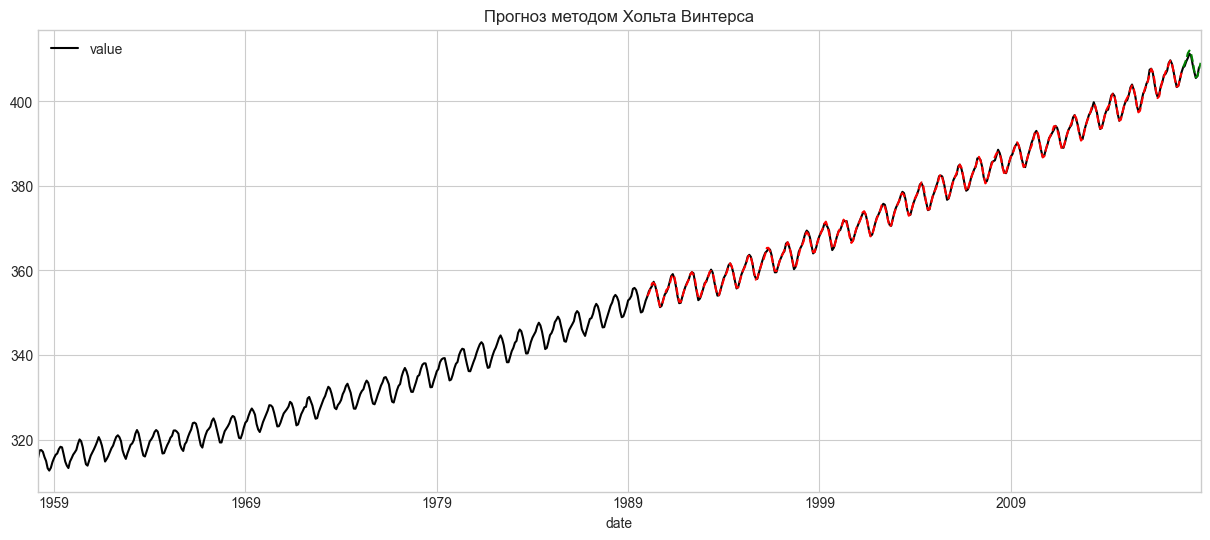

In [65]:
# візуалізація тестових і прогнозних даних
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

In [66]:
# оцінка метрик моделі Вільта-Хоферса
metrics(train, fit1.fittedvalues)

Тест на стаціонарність:
	T-статистика = -11.972
	P-значення = 0.000
Критичне значення :
	1%: -3.450141065277327 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.870258846235788 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.571415151457764 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.2402
MSE: 0.0952
MAPE: 0.0006
MPE: 0.0001
Стандартна похибка: 0.3086


#### Модель ARIMA

In [67]:
# побудова моделі
model = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=283.234, Time=1.72 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1121.858, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=782.504, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1124.912, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=414.712, Time=1.46 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=282.076, Time=4.77 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=335.829, Time=4.03 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=6.46 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=288.769, Time=4.97 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=270.302, Time=3.46 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=270.950, Time=2.77 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=336.235, Time=3.15 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

#### 5. Кінцева діагностика моделі

In [68]:
mod = sm.tsa.statespace.SARIMAX(train, order=(0, 1, 1), seasonal_order=(2, 0, 0, 12))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3588      0.048     -7.466      0.000      -0.453      -0.265
ar.S.L12       0.4751      0.049      9.699      0.000       0.379       0.571
ar.S.L24       0.5101      0.050     10.258      0.000       0.413       0.608
sigma2         0.1361      0.011     12.645      0.000       0.115       0.157


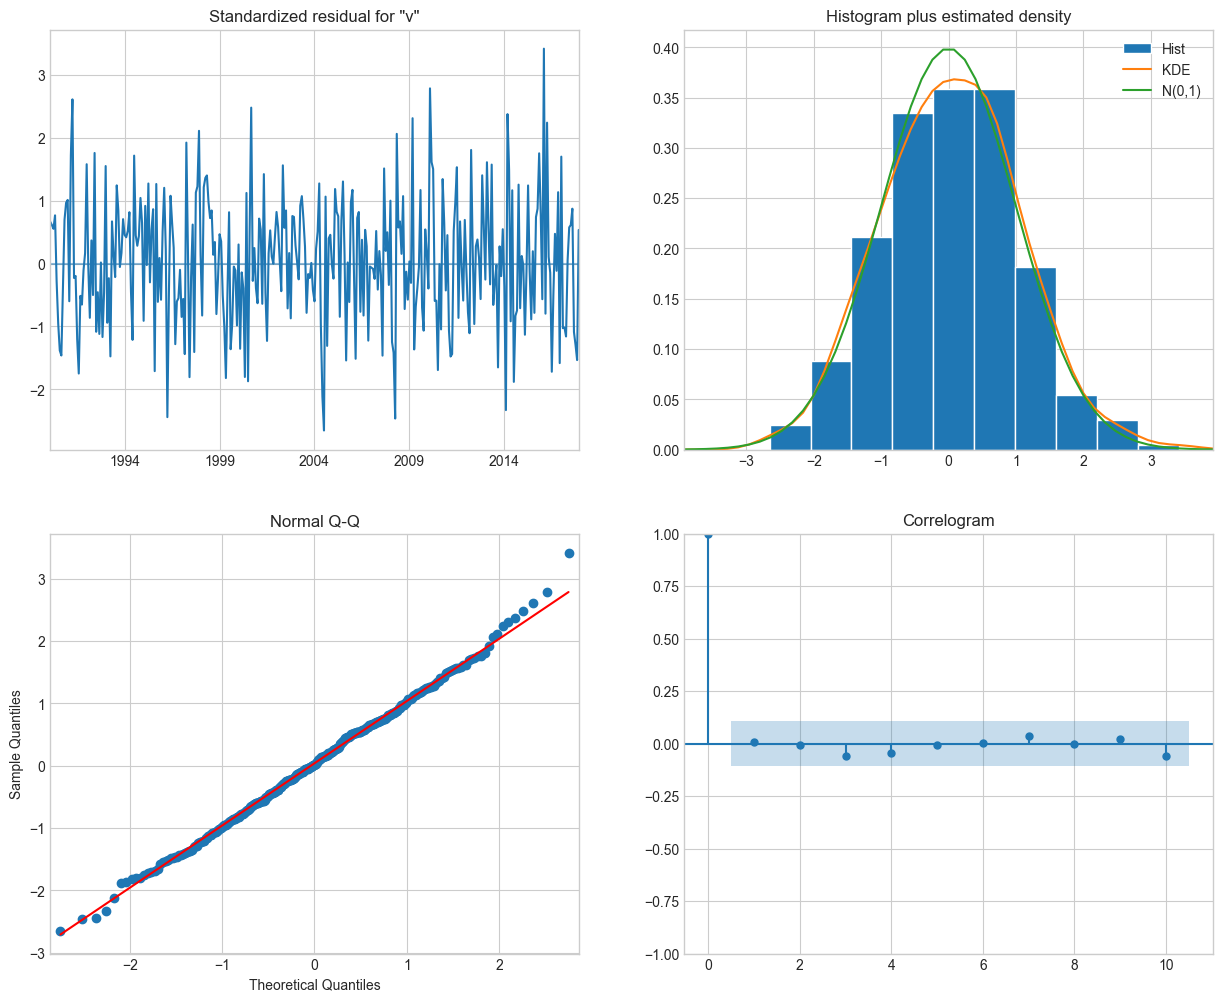

In [69]:
# візуалізація моделі тестування ARIMA
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [70]:
predict=results.get_prediction()
predict.predicted_mean[:10]

1990-01-01      0.000000
1990-02-01    353.799607
1990-03-01    354.645698
1990-04-01    355.346571
1990-05-01    355.971372
1990-06-01    356.836213
1990-07-01    356.518041
1990-08-01    355.442098
1990-09-01    353.882664
1990-10-01    352.233101
Freq: MS, Name: predicted_mean, dtype: float64

In [71]:
predict=results.get_prediction(start='1990-02-01')
metrics(train['1990-02-01':], predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -14.077
	P-значення = 0.000
Критичне значення :
	1%: -3.450081345901191 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.870232621465807 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.571401168202517 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.3381
MSE: 0.2204
MAPE: 0.0009
MPE: 0.0
Стандартна похибка: 0.4694


#### 6. Прогноз на 30 років

In [72]:
predict=results.get_prediction(start='2019', end='2049')

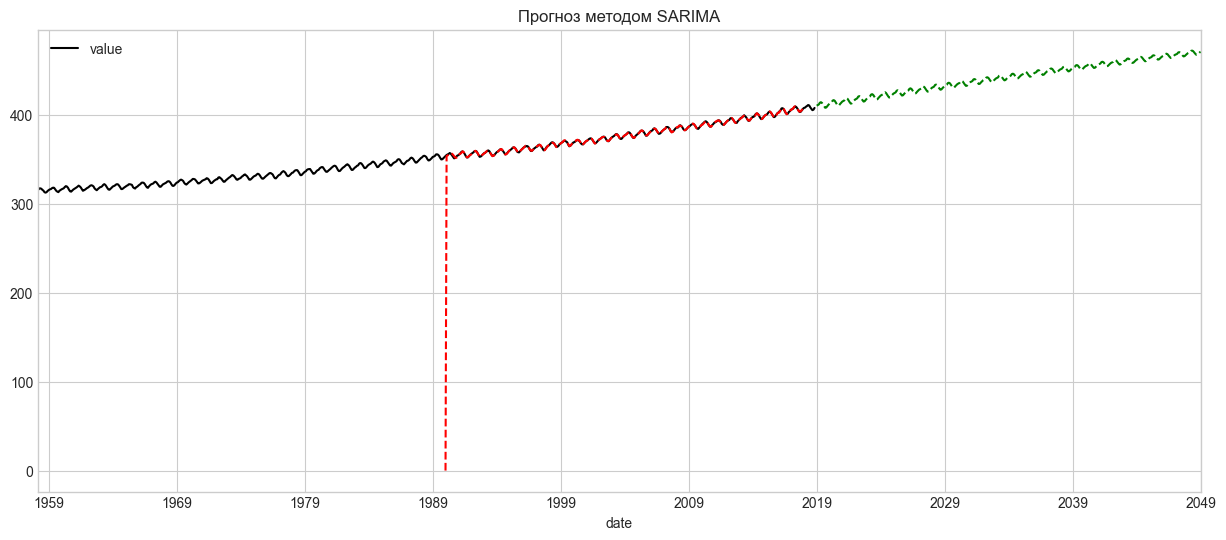

In [73]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [74]:
predict.predicted_mean

2019-01-01    410.590939
2019-02-01    411.182410
2019-03-01    411.923414
2019-04-01    413.887920
2019-05-01    414.431650
                 ...    
2048-09-01    467.782333
2048-10-01    468.043562
2048-11-01    469.256900
2048-12-01    470.302269
2049-01-01    471.270487
Freq: MS, Name: predicted_mean, Length: 361, dtype: float64

In [75]:

res_forecast=predict.predicted_mean

In [76]:
res_forecast['2018-01-01']=410

In [77]:
res_forecast

2019-01-01    410.590939
2019-02-01    411.182410
2019-03-01    411.923414
2019-04-01    413.887920
2019-05-01    414.431650
                 ...    
2048-10-01    468.043562
2048-11-01    469.256900
2048-12-01    470.302269
2049-01-01    471.270487
2018-01-01    410.000000
Name: predicted_mean, Length: 362, dtype: float64

In [78]:
df=df[:'2018-10-01'].resample('Q').sum()
df.tail()

,value
date,
2017-12-31,1215.56
2018-03-31,1225.69
2018-06-30,1232.27
2018-09-30,1221.21
2018-12-31,406.00


#### Збереження результатів прогнозування у файл

In [79]:
res_forecast.to_excel('final_cardox.xls')